In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(                  ## 64x64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),   ## 32x32
            nn.LeakyReLU(0.02),
            self._block(features_d, features_d*2, kernel_size=4, stride=2, padding=1),     ## 16x16
            self._block(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),   ## 8x8
            self._block(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1),   ## 4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),                ## 1x1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, \
                kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.02)
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, feature_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(                            ## 1x1
            self._block(z_dim, feature_g*16, 4, 1, 0),       ## 4x4
            self._block(feature_g*16, feature_g*8, 4, 2, 1), ## 8x8
            self._block(feature_g*8, feature_g*4, 4, 2, 1),  ## 16x16
            self._block(feature_g*4, feature_g*2, 4, 2, 1),  ## 32x32
            nn.ConvTranspose2d(in_channels=feature_g*2, out_channels=channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, \
                kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print('SUCCESS')

test()

SUCCESS


In [5]:
## Hyperparameters

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_D = 64
FEATURES_G = 64


print(DEVICE)

cuda:0


In [6]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)

In [7]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_G).to(DEVICE)
disc = Discriminator(CHANNELS_IMG, FEATURES_D).to(DEVICE)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch - 0/5 || 0/469 || loss D: 0.6981040835380554 || loss G: 0.755652666091919


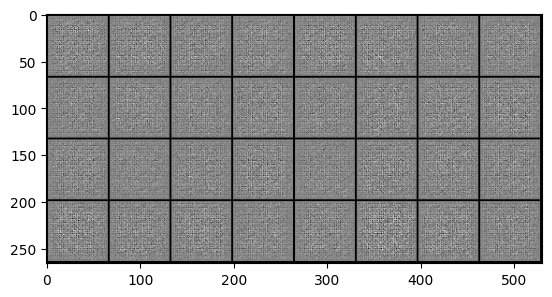

epoch - 0/5 || 100/469 || loss D: 0.016975630074739456 || loss G: 3.9093074798583984


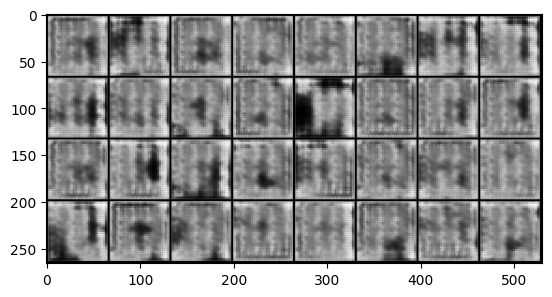

epoch - 0/5 || 200/469 || loss D: 0.4778938889503479 || loss G: 1.1758043766021729


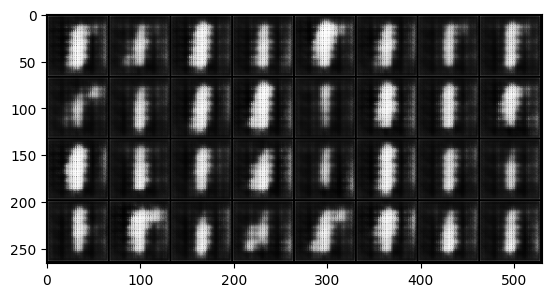

epoch - 0/5 || 300/469 || loss D: 0.6460374593734741 || loss G: 0.845034122467041


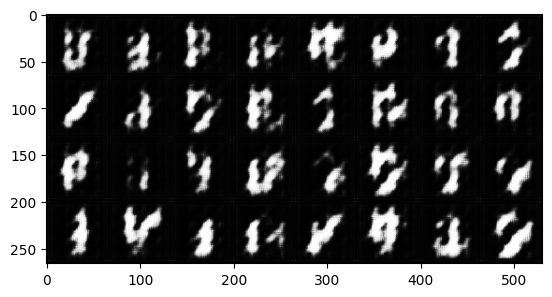

epoch - 0/5 || 400/469 || loss D: 0.5231571197509766 || loss G: 1.361757516860962


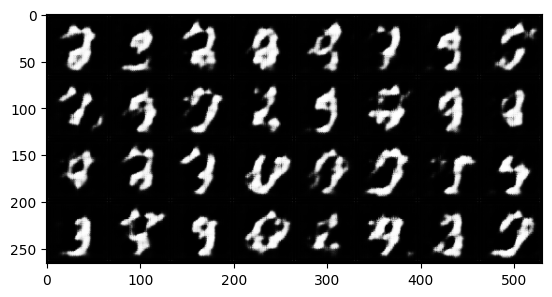

epoch - 1/5 || 0/469 || loss D: 0.6416287422180176 || loss G: 2.8132967948913574


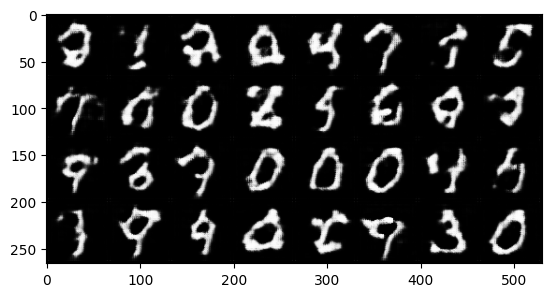

epoch - 1/5 || 100/469 || loss D: 0.4541894197463989 || loss G: 1.2018648386001587


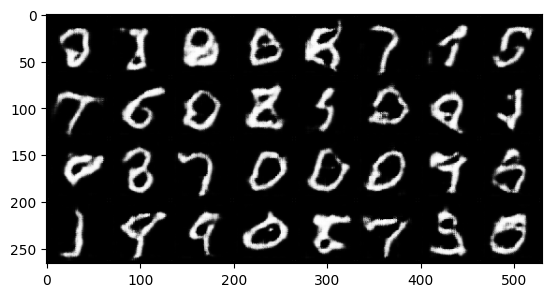

epoch - 1/5 || 200/469 || loss D: 0.5681390166282654 || loss G: 2.6570591926574707


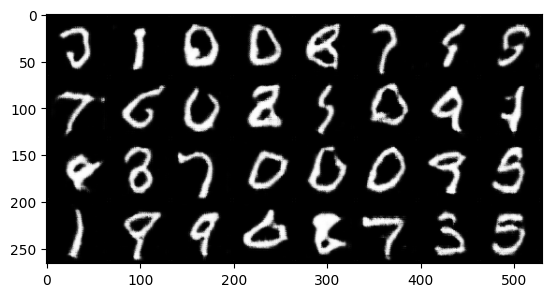

epoch - 1/5 || 300/469 || loss D: 0.3488682806491852 || loss G: 2.158083915710449


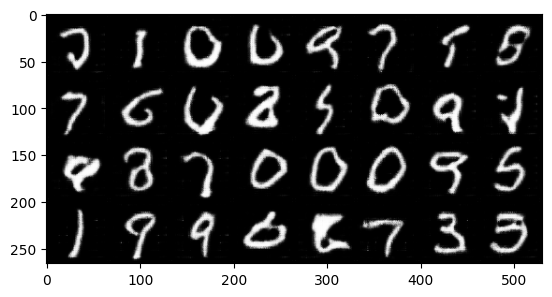

epoch - 1/5 || 400/469 || loss D: 0.5175953507423401 || loss G: 1.4200613498687744


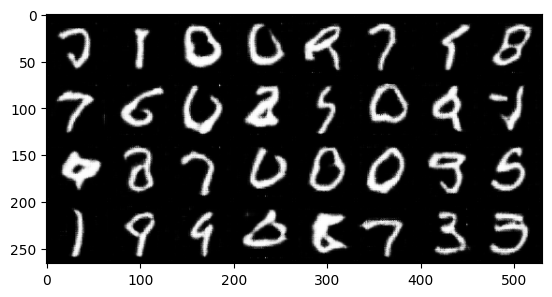

epoch - 2/5 || 0/469 || loss D: 0.40961065888404846 || loss G: 0.9259097576141357


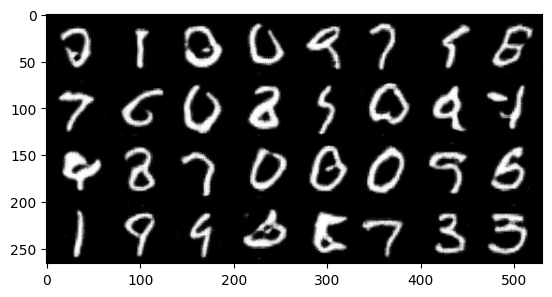

epoch - 2/5 || 100/469 || loss D: 0.2516201436519623 || loss G: 2.208481788635254


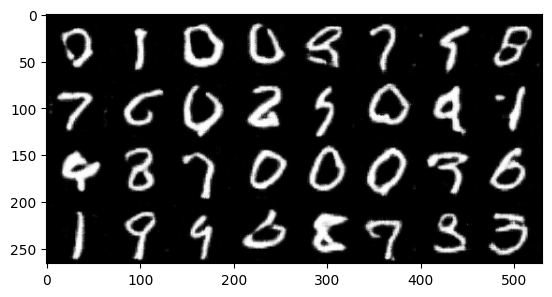

epoch - 2/5 || 200/469 || loss D: 0.25932228565216064 || loss G: 2.0126311779022217


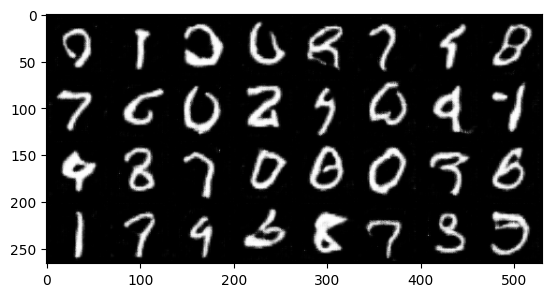

epoch - 2/5 || 300/469 || loss D: 0.21278046071529388 || loss G: 2.5044174194335938


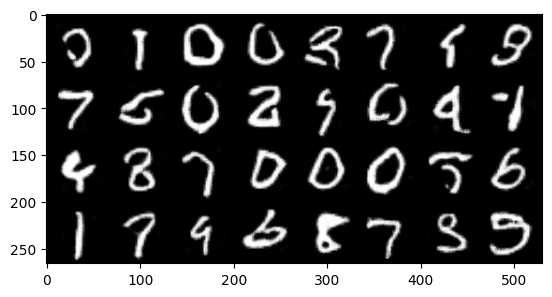

epoch - 2/5 || 400/469 || loss D: 0.20669391751289368 || loss G: 2.4641923904418945


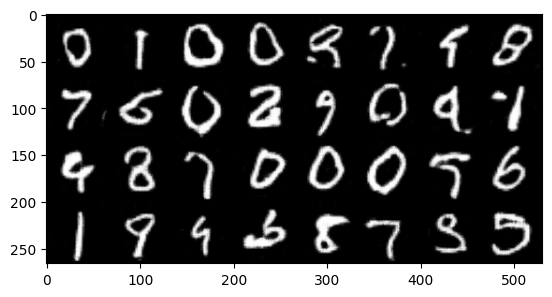

epoch - 3/5 || 0/469 || loss D: 0.22431334853172302 || loss G: 1.7389843463897705


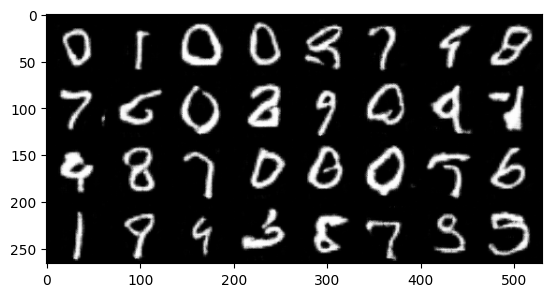

epoch - 3/5 || 100/469 || loss D: 0.1432192623615265 || loss G: 3.135258197784424


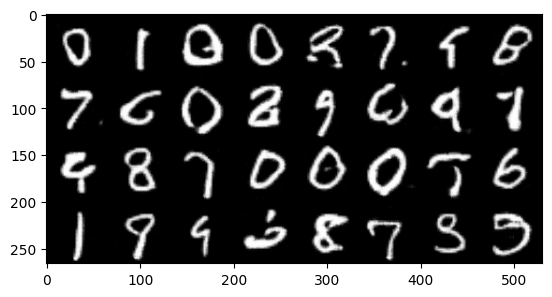

epoch - 3/5 || 200/469 || loss D: 0.17254871129989624 || loss G: 2.0654377937316895


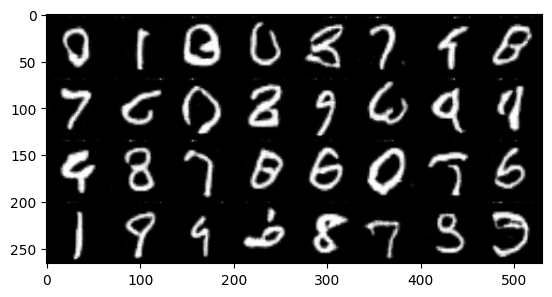

epoch - 3/5 || 300/469 || loss D: 0.16872042417526245 || loss G: 4.484659194946289


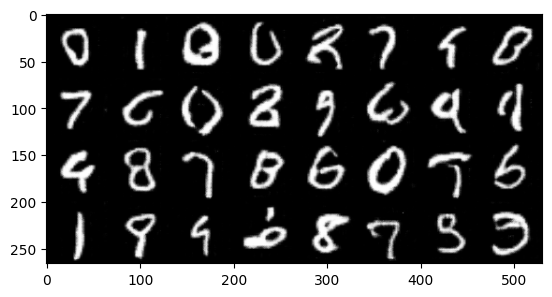

epoch - 3/5 || 400/469 || loss D: 0.02298808842897415 || loss G: 5.9519758224487305


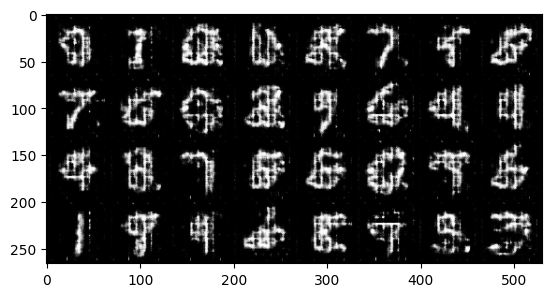

epoch - 4/5 || 0/469 || loss D: 0.397262841463089 || loss G: 4.2281575202941895


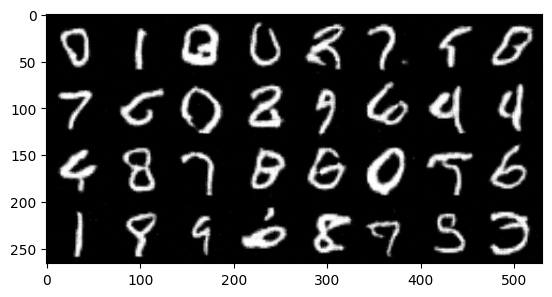

epoch - 4/5 || 100/469 || loss D: 0.33233416080474854 || loss G: 1.5257432460784912


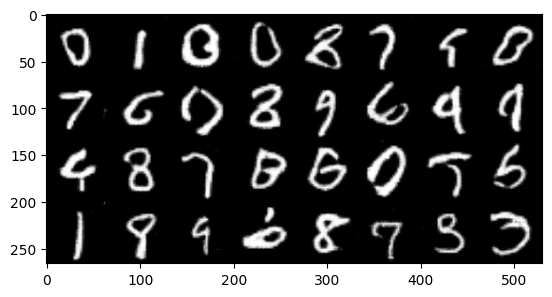

epoch - 4/5 || 200/469 || loss D: 0.39201441407203674 || loss G: 3.0912857055664062


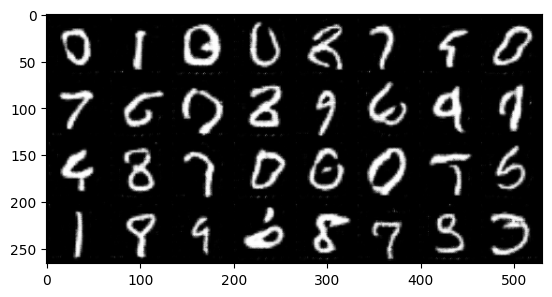

epoch - 4/5 || 300/469 || loss D: 0.28845903277397156 || loss G: 3.0242552757263184


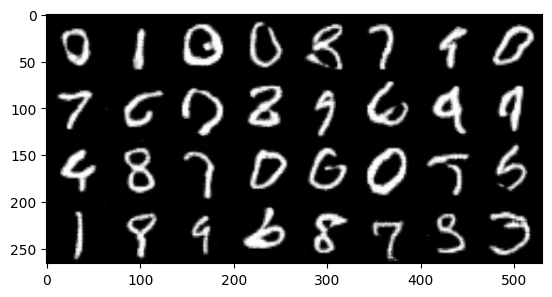

epoch - 4/5 || 400/469 || loss D: 0.136430561542511 || loss G: 2.8623337745666504


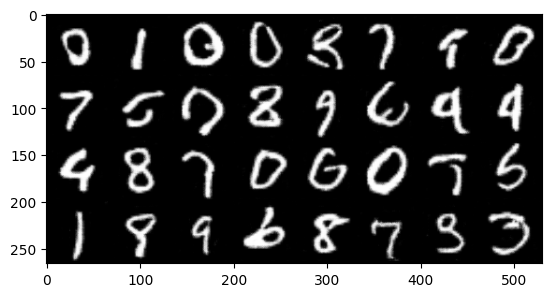

In [9]:
for epoch in range(NUM_EPOCHS):
    gen.train()
    disc.train()
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(DEVICE)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(DEVICE)
        fake = gen(noise)

        ## Train Discriminator
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        opt_disc.zero_grad()
        loss_disc.backward(retain_graph = True)
        opt_disc.step()

        ## Train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx%100 == 0:
            with torch.no_grad():
                print(f'epoch - {epoch}/{NUM_EPOCHS} || {batch_idx}/{len(loader)} || loss D: {loss_disc} || loss G: {loss_gen}')
                gen_fake_img = gen(fixed_noise)
                img_grid_fake = torchvision.utils.make_grid(
                    gen_fake_img[:32], normalize=True
                ).cpu()
                plt.imshow(img_grid_fake.permute(1, 2, 0))
                plt.show()